#### Classical SVM Implementation - Spambase 

In [47]:
# Library Imports

import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [48]:
# --- Import Spambase Column Names ---
spambase_columns = [
    "word_freq_make",
    "word_freq_address",
    "word_freq_all",
    "word_freq_3d",
    "word_freq_our",
    "word_freq_over",
    "word_freq_remove",
    "word_freq_internet",
    "word_freq_order",
    "word_freq_mail",
    "word_freq_receive",
    "word_freq_will",
    "word_freq_people",
    "word_freq_report",
    "word_freq_addresses",
    "word_freq_free",
    "word_freq_business",
    "word_freq_email",
    "word_freq_you",
    "word_freq_credit",
    "word_freq_your",
    "word_freq_font",
    "word_freq_000",
    "word_freq_money",
    "word_freq_hp",
    "word_freq_hpl",
    "word_freq_george",
    "word_freq_650",
    "word_freq_lab",
    "word_freq_labs",
    "word_freq_telnet",
    "word_freq_857",
    "word_freq_data",
    "word_freq_415",
    "word_freq_85",
    "word_freq_technology",
    "word_freq_1999",
    "word_freq_parts",
    "word_freq_pm",
    "word_freq_direct",
    "word_freq_cs",
    "word_freq_meeting",
    "word_freq_original",
    "word_freq_project",
    "word_freq_re",
    "word_freq_edu",
    "word_freq_table",
    "word_freq_conference",
    "char_freq_;",
    "char_freq_(",
    "char_freq_[",
    "char_freq_!",
    "char_freq_$",
    "char_freq_#",
    "capital_run_length_average",
    "capital_run_length_longest",
    "capital_run_length_total",
    # finally the target label column:
    "label"
]

# Load data
file_path = r'C:\Users\User\Documents\MyProjects\FYP_ResearchProject\data\spambase\spambase.data'
df = pd.read_csv(file_path, header=None, names=spambase_columns)


In [49]:
# 2. Some basic processing
print(f"Original shape of Spambase data: {df.shape}") # Prints original dataset shape
df.drop_duplicates(inplace=True) # Remove duplicates
print(f"Shape after dropping duplicates: {df.shape}\n") # Then print again the new shape

Original shape of Spambase data: (4601, 58)
Shape after dropping duplicates: (4210, 58)



In [50]:
# 3. STRATIFIED SUB-SAMPLING 

#sample_fraction = 0.20                     # change to 0.1, 0.05 … for faster runs
#X = df.drop('label', axis=1)
#y = df['label']

#X_sample, _, y_sample, _ = train_test_split(
#    X, y,
#    test_size=(1 - sample_fraction),
#    stratify=y,
#    random_state=42
#)

#print(f"Using stratified subsample of {len(X_sample)} instances "
#      f"({sample_fraction*100:.0f}% of original)\n")


#X_train, X_test, y_train, y_test = train_test_split(
#    X_sample, y_sample,
#    test_size=0.30,
#    random_state=42,
#    stratify=y_sample
#)

In [51]:
# 3. Separate features and target
X = df.drop('label', axis=1)
y = df['label']

In [52]:
# 4. Data Splitting
# Using stratify=y to ensure that class distribution is same in train and test set.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape:  {X_test.shape}")

""" 

Uses the 70/30 split with stratify y
random state - reproducitbility

""" 

Training set shape: (2947, 57)
Testing set shape:  (1263, 57)


' \n\nUses the 70/30 split with stratify y\nrandom state - reproducitbility\n\n'

In [53]:
# Scaling and PCA

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test) # use .transform not fit_transform

# Convert back to DataFrames to retain column names for the next step
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X.columns)

"""
StandardScaler - as mentioned before, it normalizes the feature to mean 0, std 1
PCA - reduces dimensionality to 4 principal components, 4 also because to match with the 4 qubit feature map
PCA - also why choose change into 4 components is to match 4 qubits of ZZFeatureMap
Also (Binary Classification) is just the classification between two classes. It does nothing to amount of qubits

Data leakage - information from test sets sneaks into the training process, makes model look better because it looks like it seen some information

""" 

'\nStandardScaler - as mentioned before, it normalizes the feature to mean 0, std 1\nPCA - reduces dimensionality to 4 principal components, 4 also because to match with the 4 qubit feature map\nPCA - also why choose change into 4 components is to match 4 qubits of ZZFeatureMap\nAlso (Binary Classification) is just the classification between two classes. It does nothing to amount of qubits\n\nData leakage - information from test sets sneaks into the training process, makes model look better because it looks like it seen some information\n\n'

In [ ]:
# --- Feature Selection ---
print("--- Feature Selection ---")
THRESH = 0.9

# Calculate correlation matrix on the SCALED TRAINING data
corr_matrix_train = X_train_scaled_df.corr().abs()

# Get the upper triangle of the correlation matrix
upper_triangle = corr_matrix_train.where(np.triu(np.ones(corr_matrix_train.shape), k=1).astype(bool))

# Find features with correlation greater than the threshold
columns_to_drop = set()
for column in upper_triangle.columns:
    high_corr_partners = upper_triangle.index[upper_triangle[column] > THRESH].tolist()
    if high_corr_partners:
        for partner in high_corr_partners:
            # IMPORTANT: Check correlation with the TRAINING target variable
            corr_main_vs_target = y_train.corr(X_train_scaled_df[column])
            corr_partner_vs_target = y_train.corr(X_train_scaled_df[partner])
            
            print(f"Found pair: ('{column}', '{partner}') with correlation > {THRESH}")
            if abs(corr_main_vs_target) < abs(corr_partner_vs_target):
                columns_to_drop.add(column)
                print(f"-> Dropping '{column}' (weaker correlation with target)")
            else:
                columns_to_drop.add(partner)
                print(f"-> Dropping '{partner}' (weaker correlation with target)")

to_drop_final = sorted(list(columns_to_drop))
print(f"\nTotal features to drop ({len(to_drop_final)}): {to_drop_final}")

# Drop the identified columns from both training and test sets
X_train_selected = X_train_scaled_df.drop(columns=to_drop_final)
X_test_selected = X_test_scaled_df.drop(columns=to_drop_final)

print(f"\nOriginal number of features: {X_train.shape[1]}")
print(f"Number of features after selection: {X_train_selected.shape[1]}\n")

--- Feature Selection ---
Found pair: ('word_freq_415', 'word_freq_857') with correlation > 0.9
-> Dropping 'word_freq_415' (weaker correlation with target)

Total features to drop (1): ['word_freq_415']

Original number of features: 57
Number of features after selection: 56



In [55]:
# PCA
n_components = 4
pca = PCA(n_components=n_components, random_state=42)

# Fit on the selected training data and transform both sets
X_train_pca = pca.fit_transform(X_train_selected)
X_test_pca = pca.transform(X_test_selected)

print(f"Shape after PCA (Train): {X_train_pca.shape}")
print(f"Shape after PCA (Test):  {X_test_pca.shape}")

Shape after PCA (Train): (2947, 4)
Shape after PCA (Test):  (1263, 4)


#### First Model - Linear SVM

In [56]:
# First SVM Model - Classical Baseline (Linear SVM)

print("--- Training Classical Linear SVM ---")
start_time_linear = time.time()

param_grid_linear = {
    'C': [0.01, 0.1, 1, 10, 100],
    'class_weight':['balanced']
}

grid_linear = GridSearchCV(SVC(kernel='linear', random_state=42), param_grid_linear, cv=5, n_jobs=-1, verbose=0)
grid_linear.fit(X_train_pca, y_train)

best_linear_svm = grid_linear.best_estimator_
training_time_linear = time.time() - start_time_linear

print(f"Best parameters found: {grid_linear.best_params_}")
print(f"Training time: {training_time_linear:.2f} seconds\n")


# Defines the grid of values for C (regularization strength).
# Uses GridSearchCV with 5-fold cross-validation → finds best C.
# Fits the Linear SVM.
# Finds the best estimator.
# Records end time → training duration.

--- Training Classical Linear SVM ---
Best parameters found: {'C': 0.1, 'class_weight': 'balanced'}
Training time: 1.16 seconds



In [57]:
# Evaluation for Linear SVM

# Predicts labels for both train and test sets
# This is where the actual prediction works
# linear_svm.predict - takes the features after all the scaling and PCA and output the predicted labels
# X_train_pca → the training data features after preprocessing.
# X_test_pca → the test data features after preprocessing.
# y_train_pred_linear → model’s predicted labels for the training set.
# y_test_pred_linear → model’s predicted labels for the test set.

y_train_pred_linear = best_linear_svm.predict(X_train_pca)
y_test_pred_linear = best_linear_svm.predict(X_test_pca)

train_accuracy_linear = accuracy_score(y_train, y_train_pred_linear)
test_accuracy_linear = accuracy_score(y_test, y_test_pred_linear)
gen_gap_linear = abs(train_accuracy_linear - test_accuracy_linear)

print("--- Linear SVM Evaluation (Spambase) ---")
print(f"Training Accuracy: {train_accuracy_linear:.4f}")
print(f"Test Accuracy:     {test_accuracy_linear:.4f}")
print(f"Generalization Gap: {gen_gap_linear:.4f}\n")

print("Classification Report (Test Set):")
print(classification_report(y_test, y_test_pred_linear))

--- Linear SVM Evaluation (Spambase) ---
Training Accuracy: 0.8714
Test Accuracy:     0.8820
Generalization Gap: 0.0106

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.90      0.90      0.90       759
           1       0.85      0.85      0.85       504

    accuracy                           0.88      1263
   macro avg       0.88      0.88      0.88      1263
weighted avg       0.88      0.88      0.88      1263



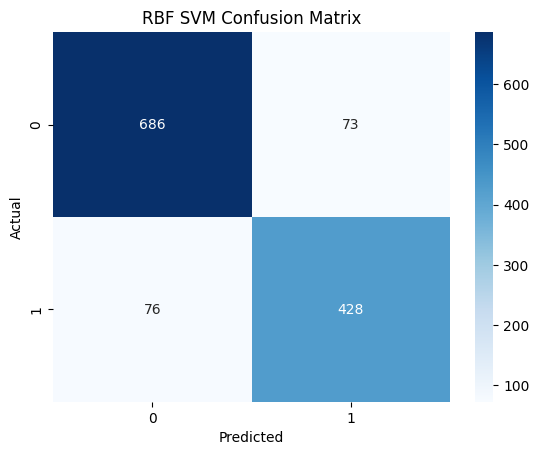

In [58]:
cm = confusion_matrix(y_test, y_test_pred_linear)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('RBF SVM Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#### Second Model - RBF SVM

In [60]:
print("--- Training Classical RBF SVM ---")
start_time_rbf = time.time()

param_grid_rbf = {
    'C': [0.01, 0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'class_weight':['balanced']
}
grid_rbf = GridSearchCV(SVC(kernel='rbf', random_state=42), param_grid_rbf, cv=5, n_jobs=-1, verbose=0)
grid_rbf.fit(X_train_pca, y_train)

best_rbf_svm = grid_rbf.best_estimator_
training_time_rbf = time.time() - start_time_rbf

print(f"Best parameters found: {grid_rbf.best_params_}")
print(f"Training time: {training_time_rbf:.2f} seconds\n")


# Defines parameter grid for C regularization and gamma (influence of each training point)
# GridSearchCV finds best (C, gamma)
# Fits RBF SVM
# Then record the training time

# C - controls the tradeoff between margin size and classification errors (Small C - big margin, Large C - Smaller margin) - Similar like the previous svm
# Gamma - decides how far the influence of a single training point reaches (Small gamma - wide influence, decision boundary smoother, less flexible ,,,, Large Gamma - narrow influence)

--- Training Classical RBF SVM ---
Best parameters found: {'C': 10, 'class_weight': 'balanced', 'gamma': 1}
Training time: 9.05 seconds



In [61]:
# Evaluation for RBF SVM
y_train_pred_rbf = best_rbf_svm.predict(X_train_pca)
y_test_pred_rbf = best_rbf_svm.predict(X_test_pca)

train_accuracy_rbf = accuracy_score(y_train, y_train_pred_rbf)
test_accuracy_rbf = accuracy_score(y_test, y_test_pred_rbf)
gen_gap_rbf = abs(train_accuracy_rbf - test_accuracy_rbf)

print("--- RBF SVM Evaluation (Spambase) ---")
print(f"Training Accuracy: {train_accuracy_rbf:.4f}")
print(f"Test Accuracy:     {test_accuracy_rbf:.4f}")
print(f"Generalization Gap: {gen_gap_rbf:.4f}\n")

print("Classification Report (Test Set):")
print(classification_report(y_test, y_test_pred_rbf))

--- RBF SVM Evaluation (Spambase) ---
Training Accuracy: 0.9131
Test Accuracy:     0.8876
Generalization Gap: 0.0256

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.91      0.90      0.91       759
           1       0.85      0.87      0.86       504

    accuracy                           0.89      1263
   macro avg       0.88      0.89      0.88      1263
weighted avg       0.89      0.89      0.89      1263



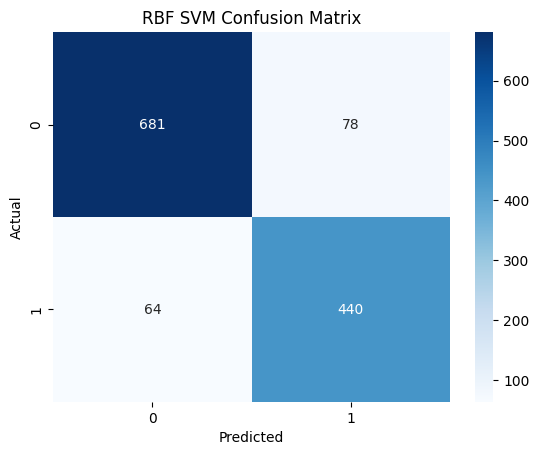

In [62]:
cm = confusion_matrix(y_test, y_test_pred_rbf)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('RBF SVM Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()